# TP Mushrooms 

(source Raphël Dion)

## Bibliothèques

In [173]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, plot_confusion_matrix, accuracy_score, recall_score,precision_score,f1_score,classification_report
from sklearn import preprocessing as pp
from sklearn.metrics import roc_curve, auc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Données

In [158]:
table = pd.read_csv('mushrooms.csv');table

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


Nous séparerons ce TP en trois parties :
<ul>
    <li> Une concernant les performances de notre réseau neuronal, à l'aide de cross-validation et de graphiques bien choisis </li>
    <li> Une deuxième mettant en action notre réseau neuronal multicouche, à l'aide d'exemples concrets </li>
    <li> Une dernière qui servira de fourretout pour d'autres idées (études de l'importance des paramètres, tentative de PCA)
</ul>

## Encodage

2 méthodes distinctes d'encodage :

* **OneHotEncoder** (non utilisé par la suite):  si une colonne contient $a$ ou $b$ alors $ a \rightarrow (1,0)$ sinon $ b \rightarrow (0,1)$ si 3 élémens $a$,$b$,$c$ alors $ a \rightarrow (1,0,0)$,  $ b \rightarrow (0,1,0)$ et $ c \rightarrow (0,0,1)$. Autrement dit chaque colonne de label et "remplacée" par autant de colonne que de label dans cette colonne (convient parfaitement a la première construction de 3 perceptrons de sortie TP1)

* **LabelEncoder** : la colonne est simplement encodé un affectant suivant le nombre distinct de Labels 0,1,2... Une colonne est transformée en 1 colonne.

L'encodage ici renvoie 2 tableaux cibles **sampleEncod** encoder avec OneHotEncoder et **targetEncod** réalisé avec LabelEncoder

la suite se fera uniquement avec **targetEncod**

In [179]:
## encodage des labels
sample = table.drop('class', axis=1)
target = table['class']

# On encode par OneHotEncoder, qui sort des vecteurs (1,0,0,...)
labelfit = pp.OneHotEncoder().fit(sample)
sampleEncod = labelfit.transform(sample)

# On encode la target par LabelEncoder, car l'on ne souhaite qu'un scalaire binaire en sortie et non un vecteur, pour les besoins des graphes
le = pp.LabelEncoder()
targetEncod = le.fit_transform(target)

# Evaluation performance

### Matrice de confusion et Score

Ici on sépare arbitrairement le jeu de donnée en 2 **sample_train** et **sample_test** afin de donner un score au modèle

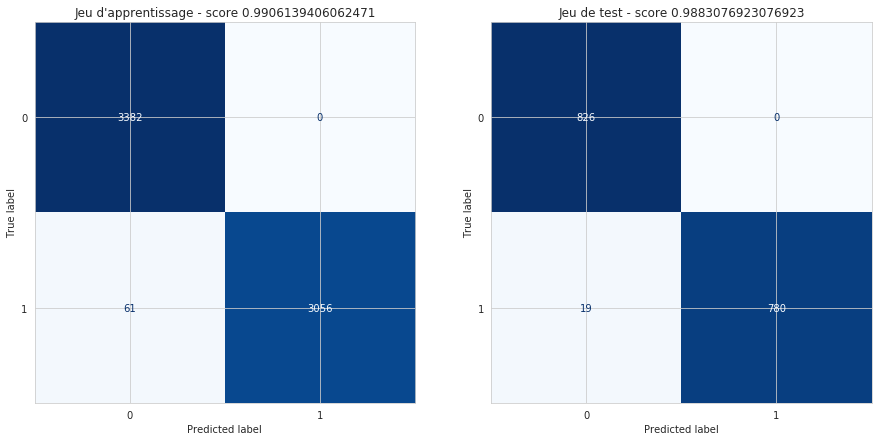

In [208]:
## séparation 

sample_train, sample_test, target_train, target_test = train_test_split(sampleEncod, targetEncod, test_size=0.2, shuffle=True)

## Model
model = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(2))
model.fit(sample_train, target_train)

## Matrice de confusion et score
# sur l'apprentissage
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
plot_confusion_matrix(model, sample_train, target_train , ax = ax[0],cmap='Blues',colorbar=False) 
predictions_train = model.predict(sample_train)
ax[0].title.set_text("Jeu d'apprentissage - score "+ str(accuracy_score(predictions_train, target_train)))
# sur l'échantillon test
predictions_test = model.predict(sample_test)
plot_confusion_matrix(model, sample_test, target_test, ax = ax[1],cmap='Blues',colorbar=False)  
ax[1].title.set_text("Jeu de test - score "+str(accuracy_score(predictions_test, target_test)))

Si on sépare cette matrice en 
* VP vrais positifs 
* VN vrais négatifs 
* FP faux positifs
* FN faux négatifs
Le s**core** est ici simplement donné comme le quotient $\displaystyle \frac{VP+VN}{VP+VN+FP+FN}$.

La **sensibilité** est définie $\displaystyle \frac{VP}{VP+FN}$ (fonction recall score)

In [161]:
recall_score(target_test, predictions_test)

0.98

La **précision** est définie  $\displaystyle \frac{VP}{VP+FP}$

In [162]:
precision_score(target_test, predictions_test)

1.0

le F1 score est une moyenne harmonique de la précision et sensibilité $F1 = \displaystyle \frac{2}{(precision)^{-1} + (sensi)^{-1}} = \frac{VP}{VP+\frac{1}{2}(FP+FN)}$

In [163]:
f1_score(target_test, predictions_test)

0.98989898989899

Enfin un fonction qui résume la situation

In [164]:
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       825
           1       1.00      0.98      0.99       800

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



# Courbe ROC et AUC

Explication : https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

référence https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html?highlight=roc

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_roc_crossval_001.png)

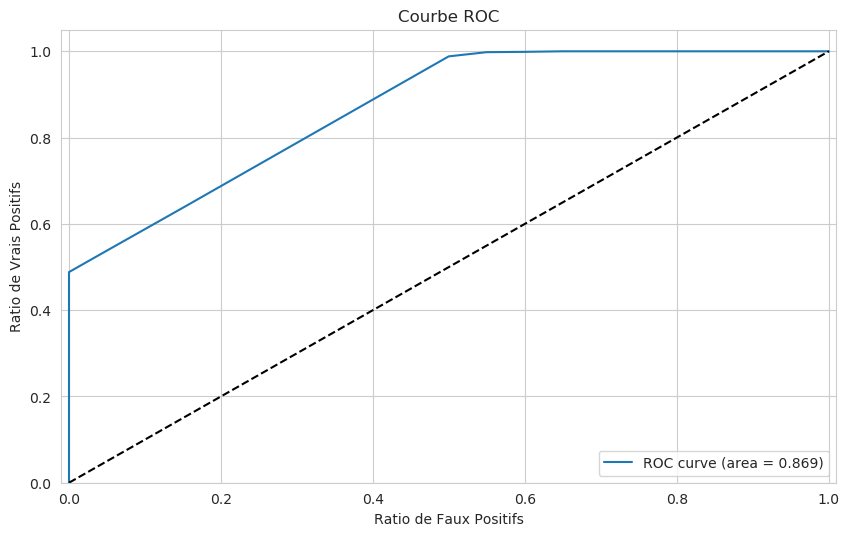

In [187]:
## Etape de la courbe ROC (Receiver Operating characteristic)
model = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(1))
mush_score = cross_val_predict( model, sampleEncod, targetEncod, cv=kfold, method="predict_proba")
fpr, tpr, th = roc_curve(y_true=targetEncod, y_score=mush_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6), dpi= 100)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Faux Positifs')
plt.ylabel('Ratio de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# A faire : mieux comprendre la signification d'une courbe ROC

## Cross-validation (K-Fold)

L'idée est de diviser l'ensemble d'apprentissage en $K$ échantillons. Tour à tour ces échantillons sont pris comme échantillon de test tandis que le reste de pris pour ensemble d'apprentissage


![Cross Validation](http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png)

## Principe utile du Cross Validation

La difficultée et de trouver la bonne topologie du réseau - nombre de couche - nombre éléments par couche - fonctions de transfert - fonction de perte - tout en évitant un sur-apprentissage. La cross validation peut répondre en nous donnant une robustesse de notre modèle à l'echantillonage

![](http://ethen8181.github.io/machine-learning/model_selection/img/hyperparameter_search.png)

Bien sûr l'objectif est d'obtenir LE modèle

![](http://ethen8181.github.io/machine-learning/model_selection/img/refit.png)

### Utilisation de cross_val_predict (scikitlearn)

Reférence : https://scikit-learn.org/stable/modules/cross_validation.html

On prend tour un tour un modèle différent et on calcule le score pour décider. Attention la cross validation dépend du nombre de K-fold que l'on prend et peux donner des scores différents...

In [232]:
## Etape de la cross-validation

# On génère des modèles 1 couche cachée
nbmodel = 10;
Model = [];
Name=[];
for i in range(0,nbmodel):
    Model.append(MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(5*i+10,10)))
    Name.append("Model"+str(i+1))

nsplits=5
results = []
for i in range(0,nbmodel):
    kfold = StratifiedKFold(n_splits=nsplits, random_state=1, shuffle=True)
    cv_results = cross_val_score(Model[i], sampleEncod, targetEncod, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    print('%s: %f (%f)' % (Name[i], cv_results.mean(), cv_results.std()))


Model1: 1.000000 (0.000000)
Model2: 1.000000 (0.000000)
Model3: 1.000000 (0.000000)
Model4: 1.000000 (0.000000)
Model5: 1.000000 (0.000000)
Model6: 1.000000 (0.000000)
Model7: 1.000000 (0.000000)
Model8: 1.000000 (0.000000)
Model9: 1.000000 (0.000000)
Model10: 1.000000 (0.000000)


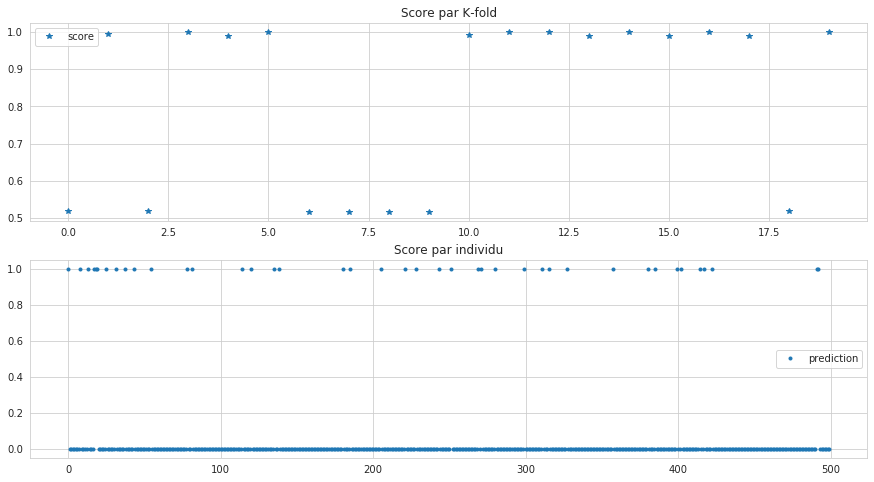

In [215]:
cv_results = cross_val_score(Model[0], sampleEncod, targetEncod, cv=kfold, scoring='accuracy')
cv_predict = cross_val_predict(Model[0], sampleEncod, targetEncod, cv=kfold)
fig, ax = plt.subplots(2)
fig.set_size_inches(15, 8)
ax[0].plot(cv_results,label='score',marker="*",linestyle = 'None')
ax[0].legend()
ax[0].title.set_text('Score par K-fold')
ax[1].plot(cv_predict[0:500],label='prediction',marker=".",linestyle = 'None')
ax[1].legend()
ax[1].title.set_text('Score par individu');

On utilise <b>shuffle = True</b> dans le <b>cross_val_score</b>. Si l'on ne mélangeait pas, étant donné que l'échantillon est rangé par classe, la précision baisserait.

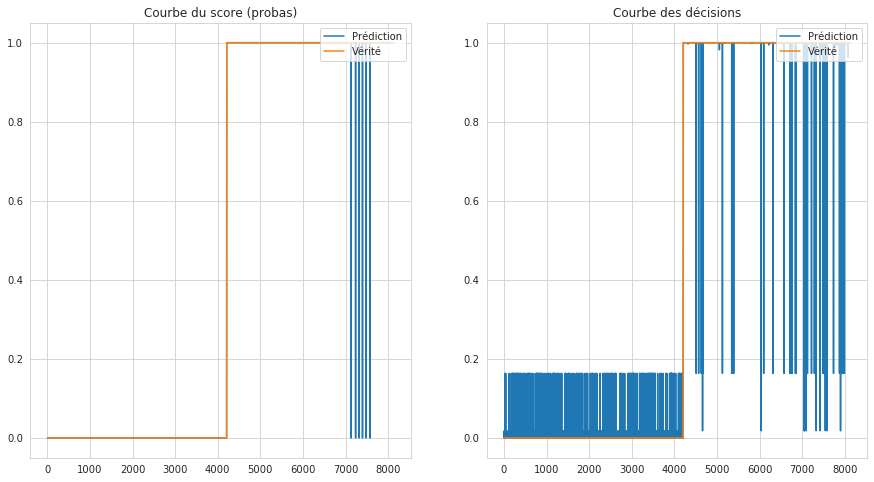

In [217]:
mush_score = cross_val_predict( Model[2], sampleEncod, targetEncod, cv=kfold)
mush_predict = cross_val_predict( Model[2], sampleEncod, targetEncod, cv=kfold, method="predict_proba")

ordre = np.argsort(targetEncod) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
# Courbe des probas (score)
ax1.plot(mush_score[ordre],label="Prédiction")
ax1.plot(targetEncod[ordre],label="Vérité")

ax1.legend(loc="upper right")
ax1.title.set_text('Courbe du score (probas)')

# Courbe des décisions
ax2.plot(mush_predict[ordre,1],label="Prédiction")
ax2.plot(targetEncod[ordre],label="Vérité")

ax2.legend(loc="upper right")
ax2.title.set_text('Courbe des décisions')
plt.show()

# Autres idées DION

## Régression linéaire

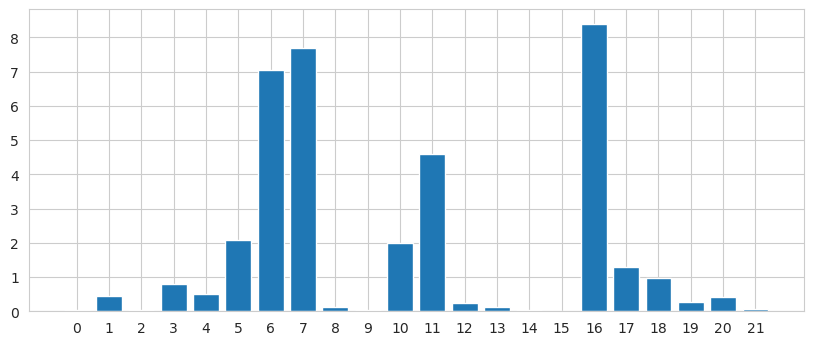

In [221]:
# Ici on va se servir d'une régression logistique pour obtenir les variables "les plus importantes"

from sklearn.linear_model import LogisticRegression

sample = table.drop('class', axis=1)
for num in sample.columns :
    sample[num] = pp.LabelEncoder().fit_transform(sample[num])

target = pp.LabelEncoder().fit_transform(table['class'])

lr = LogisticRegression(max_iter = 500)
lr.fit(sample,target)
importance = lr.coef_[0] 
plt.figure(figsize=(10,4), dpi= 100)
plt.bar([x for x in range(len(importance))], abs(importance))
plt.xticks([x for x in range(len(importance))], range(0,22))
plt.show()

In [225]:
def infos_mush(n):
    """
    Cette fonction permet d'identifier la n-ième colonne d'information des champignons, ce qui est notamment utile par rapport au graphe ci-dessus
    """
    return sample.columns[n]

In [226]:
from sklearn.decomposition import PCA
sample = table.drop('class', axis=1)
for num in sample.columns :
    sample[num] = pp.LabelEncoder().fit_transform(sample[num]) # Cette étape sert à avoir des données numériques et non textuelles

target = pp.LabelEncoder().fit_transform(table['class'])

sample['class'] = target
model = PCA(n_components=4)
reduc = model.fit_transform(sample)
sample['PCA1'] = reduc[:, 0]
sample['PCA2'] = reduc[:, 1]
sample['PCA3'] = reduc[:, 2]
sample['PCA4'] = reduc[:, 3]

<Figure size 1000x800 with 0 Axes>

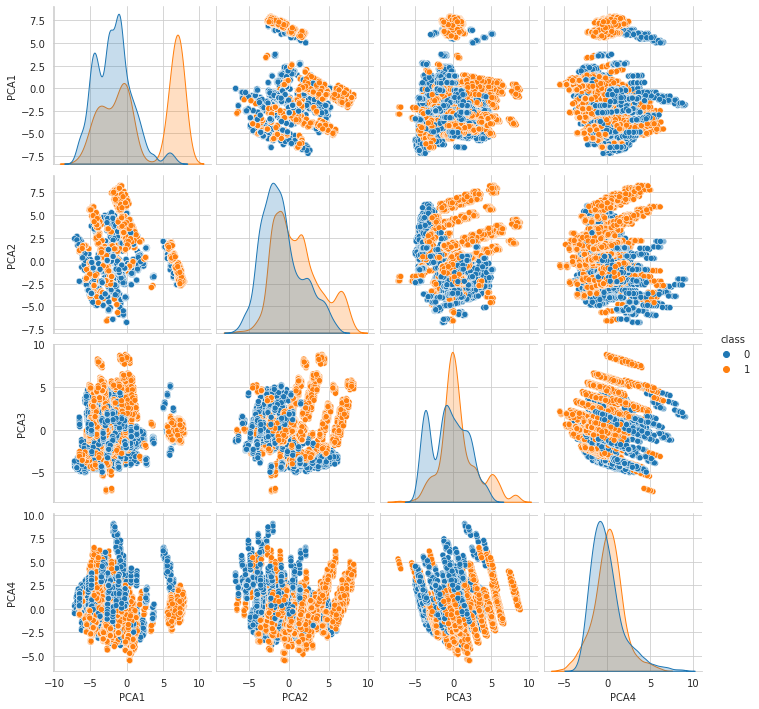

In [178]:
plt.figure(figsize=(10,8), dpi= 100)
sns.set_style("whitegrid")
sns.pairplot(sample[['PCA1','PCA2','PCA3','PCA4','class']],hue="class");


In [229]:
sample[['PCA1','PCA2','PCA3','PCA4','class']]

,PCA1,PCA2,PCA3,PCA4,class
0,0.253155,-0.328937,-1.394706,-1.234410,1
1,-1.951883,4.744446,-3.575813,-1.248792,0
2,-1.677844,2.410486,-3.920792,1.220037,0
3,-1.221569,1.685836,-3.547210,0.599113,1
4,1.544142,-1.054200,-1.282584,-1.980693,0
...,...,...,...,...,...
8119,-6.493231,-2.288384,0.615113,1.117927,0
8120,-6.546385,-2.250222,1.461294,0.331681,0
8121,-1.883013,0.458846,1.161857,-0.317718,0
8122,7.304887,-1.275485,-1.232672,0.782162,1
